In [4]:
import math
import numpy as np
import pandas as pd

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

from datetime import datetime, timedelta
import re

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)

In [6]:
crc_df = pd.read_csv('Data/CRC_2016to2020_comprehensive.csv')
lca_df = pd.read_csv('Data/LCa_2016to2020_comprehensive.csv')

In [7]:
# this is to only select patients matching exclusion criteria, as the comprehensive dataset also contains the others
crc_df = crc_df[crc_df['HasPCPAfterCutOff'] == 1]
lca_df = lca_df[lca_df['HasPCPAfterCutOff'] == 1]

In [16]:
# select only columns we need
crc_df_trimmed = crc_df[['Time365', 'DeathStatus365', 'EP', 'PatientRace', 'PatientSex', 'PatientAge', 'StageOfCancer']].copy()
lca_df_trimmed = lca_df[['Time365', 'DeathStatus365', 'EP', 'PatientRace', 'PatientSex', 'PatientAge', 'StageOfCancer']].copy()

In [17]:
# encode race as seperate columns for regression since categorical
crc_df_trimmed['IsNHB'] = crc_df_trimmed.apply(lambda row : 1 if row['PatientRace'] == 1 else 0, axis=1)
crc_df_trimmed['IsHispanic'] = crc_df_trimmed.apply(lambda row : 1 if row['PatientRace'] == 2 else 0, axis=1)
crc_df_trimmed['IsNHW'] = crc_df_trimmed.apply(lambda row : 1 if row['PatientRace'] == 3 else 0, axis=1)
crc_df_trimmed['IsOtherRace'] = crc_df_trimmed.apply(lambda row : 1 if row['PatientRace'] == 4 else 0, axis=1)
crc_df_trimmed = crc_df_trimmed.drop('PatientRace', axis=1)

lca_df_trimmed['IsNHB'] = lca_df_trimmed.apply(lambda row : 1 if row['PatientRace'] == 1 else 0, axis=1)
lca_df_trimmed['IsHispanic'] = lca_df_trimmed.apply(lambda row : 1 if row['PatientRace'] == 2 else 0, axis=1)
lca_df_trimmed['IsNHW'] = lca_df_trimmed.apply(lambda row : 1 if row['PatientRace'] == 3 else 0, axis=1)
lca_df_trimmed['IsOtherRace'] = lca_df_trimmed.apply(lambda row : 1 if row['PatientRace'] == 4 else 0, axis=1)
lca_df_trimmed = lca_df_trimmed.drop('PatientRace', axis=1)

In [20]:
# split the data into EP and non-EP groups for each cancer to make things easier
crc_df_ep = crc_df_trimmed[crc_df_trimmed['EP'] == 1].drop('EP', axis=1)
crc_df_rt = crc_df_trimmed[crc_df_trimmed['EP'] == 0].drop('EP', axis=1)

lca_df_ep = lca_df_trimmed[lca_df_trimmed['EP'] == 1].drop('EP', axis=1)
lca_df_rt = lca_df_trimmed[lca_df_trimmed['EP'] == 0].drop('EP', axis=1)

In [25]:
# fit the data to a Kaplan Meier model
kmf_crc_ep = KaplanMeierFitter()
kmf_crc_rt = KaplanMeierFitter()
kmf_lca_ep = KaplanMeierFitter()
kmf_lca_rt = KaplanMeierFitter()

kmf_crc_ep.fit(durations = crc_df_ep['Time365'], event_observed=crc_df_ep['DeathStatus365'], label='EP')
kmf_crc_rt.fit(durations = crc_df_rt['Time365'], event_observed=crc_df_rt['DeathStatus365'], label='Routine')

kmf_lca_ep.fit(durations = lca_df_ep['Time365'], event_observed=lca_df_ep['DeathStatus365'], label='EP')
kmf_lca_rt.fit(durations = lca_df_rt['Time365'], event_observed=lca_df_rt['DeathStatus365'], label='Routine')

<lifelines.KaplanMeierFitter:"Routine", fitted with 29653 total observations, 19721 right-censored observations>

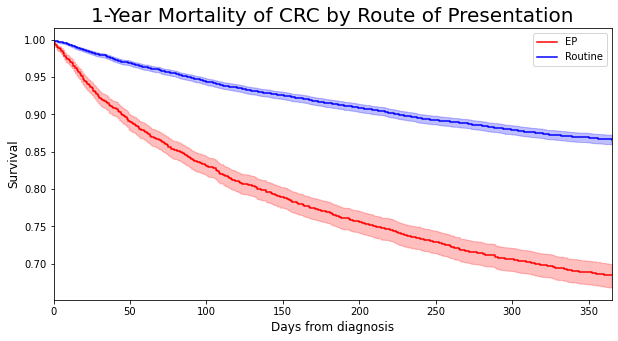

In [26]:
# plot km curves
fig, ax = plt.subplots(figsize=(10,5))

kmf_crc_ep.plot(color='r')
kmf_crc_rt.plot(color='b')

plt.title("1-Year Mortality of CRC by Route of Presentation (2016-2020)", fontsize=20)
plt.xlabel ("Days from diagnosis", fontsize=12)
plt.ylabel ("Survival", fontsize=12)

plt.xlim([0,365])
plt.show()

In [30]:
# assess significance
logrank_crc = logrank_test(durations_A = crc_df_ep['Time365'], durations_B = crc_df_rt['Time365'], event_observed_A = crc_df_ep['DeathStatus365'], event_observed_B = crc_df_rt['DeathStatus365'])
logrank_crc.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         656.97 <0.005    478.91

In [65]:
cph_crc = CoxPHFitter()
# only rows where we have cancer stage
crc_df_cox = crc_df_trimmed[crc_df_trimmed['StageOfCancer']!=0]
# drop 1 of the dummy vars for cat value col
crc_df_cox = crc_df_cox.drop(['IsOtherRace'], axis=1)

<AxesSubplot:xlabel='log(HR) (95% CI)'>

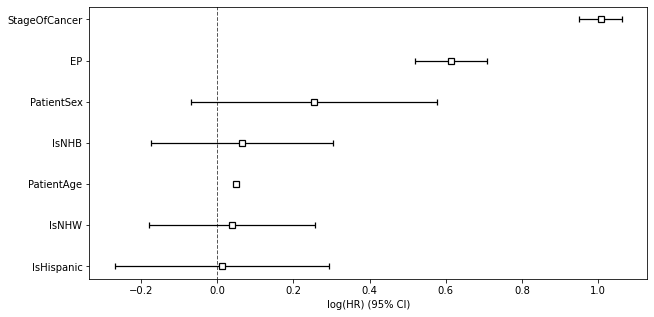

In [58]:
cph_crc.fit(crc_df_cox, duration_col='Time365', event_col='DeathStatus365')
cph_crc.plot()

In [59]:
cph_crc.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
EP,0.612882,1.845743,0.048429,0.517962,0.707802,1.678604,2.029525,12.655180,1.047357e-36,119.522658
PatientSex,0.254687,1.290058,0.164857,-0.068427,0.577801,0.933862,1.782115,1.544897,1.223711e-01,3.030665
PatientAge,0.048740,1.049947,0.002322,0.044189,0.053290,1.045180,1.054736,20.991980,7.764278e-98,322.592102
StageOfCancer,1.006286,2.735422,0.028586,0.950259,1.062313,2.586378,2.893055,35.202205,1.850083e-271,899.354924
IsNHB,0.066043,1.068273,0.121708,-0.172500,0.304587,0.841558,1.356065,0.542638,5.873792e-01,0.767636
IsHispanic,0.013354,1.013443,0.143595,-0.268088,0.294795,0.764841,1.342851,0.092996,9.259066e-01,0.111061
IsNHW,0.038888,1.039654,0.111516,-0.179680,0.257456,0.835538,1.293635,0.348724,7.272966e-01,0.459384


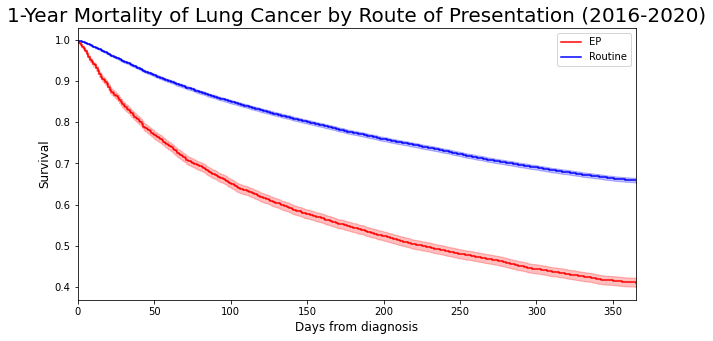

In [66]:
# plot km curves
fig, ax = plt.subplots(figsize=(10,5))

kmf_lca_ep.plot(color='r')
kmf_lca_rt.plot(color='b')

plt.title("1-Year Mortality of Lung Cancer by Route of Presentation (2016-2020)", fontsize=20)
plt.xlabel ("Days from diagnosis", fontsize=12)
plt.ylabel ("Survival", fontsize=12)

plt.xlim([0,365])
plt.show()

In [31]:
# assess signiicance 
logrank_lca = logrank_test(durations_A = lca_df_ep['Time365'], durations_B = lca_df_rt['Time365'], event_observed_A = lca_df_ep['DeathStatus365'], event_observed_B = lca_df_rt['DeathStatus365'])
logrank_lca.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        2166.50 <0.005       inf

In [62]:
cph_lca = CoxPHFitter()
# only rows where we have cancer stage
lca_df_cox = lca_df_trimmed[lca_df_trimmed['StageOfCancer']!=0]
# drop 1 of the dummy vars for cat value col
lca_df_cox = lca_df_cox.drop(['IsOtherRace'], axis=1)

<AxesSubplot:xlabel='log(HR) (95% CI)'>

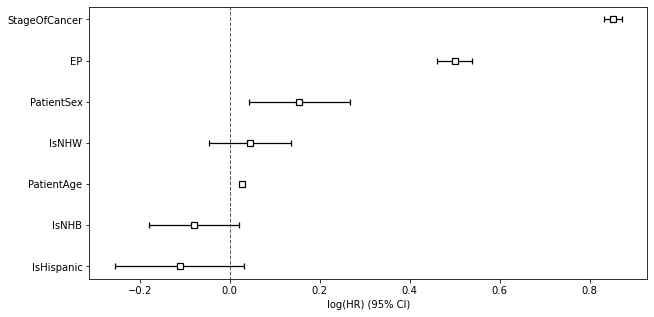

In [63]:
cph_lca.fit(lca_df_cox, duration_col='Time365', event_col='DeathStatus365')
cph_lca.plot()

In [64]:
cph_lca.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
EP,0.499781,1.648361,0.019791,0.460992,0.538571,1.585646,1.713556,25.253092,1.047362e-140,465.003173
PatientSex,0.154127,1.166639,0.057021,0.042367,0.265886,1.043278,1.304586,2.702975,6.872186e-03,7.185015
PatientAge,0.026729,1.027090,0.001126,0.024522,0.028936,1.024826,1.029359,23.739434,1.412700e-124,411.420629
StageOfCancer,0.851877,2.344044,0.010063,0.832154,0.871601,2.298264,2.390735,84.653660,0.000000e+00,inf
IsNHB,-0.080172,0.922958,0.050768,-0.179675,0.019332,0.835541,1.019520,-1.579182,1.142943e-01,3.129174
IsHispanic,-0.111842,0.894185,0.073374,-0.255654,0.031969,0.774410,1.032485,-1.524268,1.274417e-01,2.972090
IsNHW,0.044770,1.045787,0.046387,-0.046147,0.135686,0.954901,1.145322,0.965133,3.344781e-01,1.580016
